In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix,
    plot_confusion_matrix, make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay)

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.dummy import DummyClassifier

import warnings

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

rng = 2308168484 #int(np.random.default_rng().random()*(2**32))

%matplotlib inline
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data_weekly_class.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=False)
df.head(2)

,date,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons,rig_change_4bin_week+4,rig_change_4bin_week+8,rig_pct_change_week+4,rig_pct_change_week+8
0,2020-08-14,172.0,23.464,37.872,42.076,44.538,42.094,42.364,42.692,42.996,...,37.872,42.782417,37.872,51.707156,37.872,94.489573,++,++,0.046512,0.122093
1,2020-08-07,176.0,15.712,37.322,41.568,44.356,41.614,41.868,42.214,42.514,...,37.322,42.807514,37.322,51.382073,37.322,94.189587,++,++,0.028409,0.073864


In [4]:
num_col_rig_change = df.columns.str.contains('rig_').sum()

df.columns

Index(['date', 'Total US RigCount', 'wti_spot_lag_15', 'wti_spot_lag_9',
       'wti_spot', 'brent_spot', 'wti_fut_1', 'wti_fut_2', 'wti_fut_3',
       'wti_fut_4', 'usa_net_import_smooth', 'usa_net_import',
       'usa_stocks_all', 'usa_stocks_spr', 'usa_l48_prod_smooth',
       'usa_l48_prod', 'opec_tot_prod', 'opec_crud_capac', 'opec_surp_capac',
       'non-opec_tot_prod', 'oecd_cons_smooth', 'oecd_cons',
       'non-oecd_cons_smooth', 'non-oecd_cons', 'world_cons_smooth',
       'world_cons', 'rig_change_4bin_week+4', 'rig_change_4bin_week+8',
       'rig_pct_change_week+4', 'rig_pct_change_week+8'],
      dtype='object')

In [5]:
df = df.drop(['brent_spot','wti_fut_1','wti_fut_2','wti_fut_3','wti_fut_4','usa_l48_prod','world_cons_smooth','world_cons','oecd_cons','non-oecd_cons','non-oecd_cons_smooth','usa_stocks_all'],axis=1)

In [6]:
df = df.drop(['wti_spot_lag_15','wti_spot_lag_9'],axis=1)

In [7]:
df.shape

(498, 16)

## Train Test Split
Define features X, and target variable y

In [8]:
X = pd.concat([df.iloc[:,2:-num_col_rig_change],df[df.columns[df.columns.str.contains('rig_pct')]]],axis=1)
y = df.loc[:,'rig_change_4bin_week+8']

old_class = ['--','-','+','++']
new_class = [int(0),int(1),int(2),int(3)]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=rng)

pct_change_train = X_train[X_train.columns[X_train.columns.str.contains('rig_pct')]]
pct_change_test = X_test[X_train.columns[X_train.columns.str.contains('rig_pct')]]

X_train = X_train[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X_test = X_test[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X = df.iloc[:,2:-num_col_rig_change]

model_score = pd.DataFrame(columns=['accuracy','balanced accuracy','precision avg','recall avg','precision (++)','precision (+)','precision (-)','precision (--)','recall (++)','recall (+)','recall (-)','recall (--)','pos neg class','max depth'])

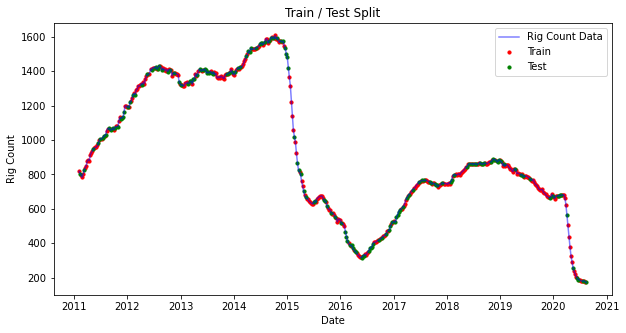

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.date,df['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
ax.scatter(df.date[y_train.sort_index().index],df['Total US RigCount'][y_train.sort_index().index],c='r',alpha=1,s=10,label='Train')
ax.scatter(df.date[y_test.sort_index().index],df['Total US RigCount'][y_test.sort_index().index], c='g',alpha=1,s=10,label='Test')
    
ax.set(title='Train / Test Split',xlabel='Date',ylabel='Rig Count')
ax.legend()
plt.show()

In [10]:
# Define functions
def data_split_week(X,y,pipe,model_name,seed):
    
    for i in range(1,31):
        X_train, X_test, y_train, y_test = train_test_split(X,y['rig_change_4bin_week+'+str(i)],test_size=0.33,random_state=seed)

        pipe.fit(X_train,y_train)

        y_pred = pipe.predict(X_test)

        add_model_score(pipe,model_name+'_week+'+str(i),y_test,y_pred)
    
    return model_score.tail(30), pipe

def add_model_score(model,model_name,y_test,y_pred):
    model_score.loc[model_name,'accuracy'] = accuracy_score(y_test,y_pred)    
    model_score.loc[model_name,'balanced accuracy'] = balanced_accuracy_score(y_test,y_pred)
    
    precision_arr = precision_score(y_test,y_pred,average=None,labels=['++','+','-','--'])
    recall_arr = recall_score(y_test,y_pred,average=None,labels=['++','+','-','--'])
    
    precision_arr_weight = precision_score(y_test,y_pred,average='weighted',labels=['++','+','-','--']) 
    recall_arr_weight = recall_score(y_test,y_pred,average='weighted',labels=['++','+','-','--'])
    
    model_score.loc[model_name,'precision avg'] = precision_arr_weight
    model_score.loc[model_name,'recall avg'] = recall_arr_weight
    
    model_score.loc[model_name,'precision (++)'] = precision_arr[0]
    model_score.loc[model_name,'precision (+)'] = precision_arr[1]
    model_score.loc[model_name,'precision (-)'] = precision_arr[2]
    model_score.loc[model_name,'precision (--)'] = precision_arr[3]
    
    model_score.loc[model_name,'recall (++)'] = recall_arr[0]
    model_score.loc[model_name,'recall (+)'] = recall_arr[1]
    model_score.loc[model_name,'recall (-)'] = recall_arr[2]
    model_score.loc[model_name,'recall (--)'] = recall_arr[3]
    
    model_score.loc[model_name,'pos neg class'] = scorer_pos_neg_class(y_test,y_pred)
    
    if ('RFC' in model_name) or ('XGB' in model_name):
        
        if ~('base' in model_name):
            model_score.loc[model_name,'max depth'] = model.best_estimator_.named_steps.model.max_depth
        else:
            model_score.loc[model_name,'max depth'] = np.nan
    else : 
        model_score.loc[model_name,'max depth'] = np.nan
    
    return model_score[model_score.index == model_name]
    
def feat_imp(model):
    plt.subplots(figsize=(10, 5))
    imps = model.best_estimator_.named_steps.model.feature_importances_
    rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
    rf_feat_imps.plot(kind='bar')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Best feature importances');
    
    return plt.show()


def plot_feat_opti(grid_params,param_range,scoring):

    param_series = pd.Series([],dtype=float)
    param_range = param_range

    for param in param_range:
        
        pipe = GridSearchCV(make_pipeline(scaler,model),scoring='recall_weighted',param_grid=grid_params,cv=5,n_jobs=-1)

        pipe.fit(X_train,y_train)

        y_pred = pipe.predict(X_test)
      
        param_series = param_series.append(pd.Series(scoring(y_test,y_pred)),ignore_index=True)
    
    return plt.plot(param_range,param_series,marker='o')

def scorer_pos_neg_class(y_test,y_pred):
    mat_conf = confusion_matrix(y_test,y_pred)

    pos_2_neg = mat_conf[[0,1],2:].sum()
    neg_2_pos = mat_conf[[2,3],:2].sum()

    pos_neg_misclass = 1-(pos_2_neg+neg_2_pos)/mat_conf.sum()
    
    return pos_neg_misclass

def scorer_confusion_matrix(y_test,y_pred):
    return confusion_matrix(y_test,y_pred)

recall_neg_scorer = make_scorer(recall_score,average=None,labels=['-'],greater_is_better=True)
pos_neg_class_scorer = make_scorer(scorer_pos_neg_class,greater_is_better=True)

confusion_matrix_scorer = make_scorer(scorer_confusion_matrix)

## Baseline Dummy Classifier

In [11]:
model = DummyClassifier(strategy='stratified')
scaler = StandardScaler()
feat_sel = SelectKBest(score_func=f_classif)

grid_params = {
    'model__random_state' : [403], #np.arange(1,1000,step=1),
    'feat_sel__k': [4], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

model_name = 'baseline_dummy_class'

base_dummy_pipe = GridSearchCV(Pipeline([('feat_sel',feat_sel),('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

base_dummy_pipe.fit(X_train,y_train)

y_pred = base_dummy_pipe.predict(X_test)

add_model_score(base_dummy_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
baseline_dummy_class,0.260606,0.250352,0.26108,0.260606,0.210526,0.375,0.147059,0.266667,0.186047,0.375,0.16129,0.27907,0.509091,NaN


In [12]:
pd.Series(base_dummy_pipe.best_estimator_.named_steps.feat_sel.scores_[base_dummy_pipe.best_estimator_.named_steps.feat_sel.get_support()], index=X.columns[base_dummy_pipe.best_estimator_.named_steps.feat_sel.get_support()]).sort_values(ascending=False)

wti_spot                 40.642929
usa_l48_prod_smooth      29.375103
usa_net_import_smooth    28.072904
usa_net_import           27.017114
dtype: float64

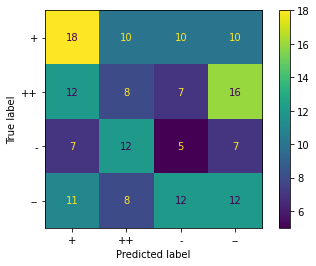

In [13]:
plot_confusion_matrix(base_dummy_pipe,X_test,y_test)

## KMeans Clustering

In [14]:
y_kmeans_train = y_train.copy()
y_kmeans_test = y_test.copy()

for i in range(len(old_class)):
    y_kmeans_train[y_kmeans_train == old_class[i]] = new_class[i]
    y_kmeans_test[y_kmeans_test == old_class[i]] = new_class[i]


In [15]:
model = KMeans(n_clusters = 4)
model_name = 'KMeans_base'

KM_base_pipe = Pipeline([('model',model)])

KM_base_pipe.fit(X_train,y_kmeans_train)

y_pred = KM_base_pipe.predict(X_test)

In [16]:
y_km_test_labelled = y_kmeans_test.copy()
y_pred_labelled = pd.Series(y_pred).copy()

for i in range(len(old_class)):
    y_km_test_labelled[y_km_test_labelled == new_class[i]] = old_class[i]
    y_pred_labelled[y_pred_labelled == new_class[i]] = old_class[i]

add_model_score(model,model_name,y_km_test_labelled,y_pred_labelled)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
KMeans_base,0.109091,0.119628,0.13212,0.109091,0.166667,0.0877193,0.258065,0.056338,0.0232558,0.104167,0.258065,0.0930233,0.430303,NaN


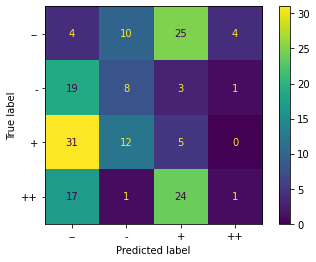

In [17]:
cm = confusion_matrix(y_km_test_labelled,y_pred_labelled,labels=old_class)

ConfusionMatrixDisplay(cm,display_labels=old_class).plot()

Terrible performance from the base KMeans. Worse than random guess (1/4), and 50% of the points are incorrectly classified between negative and positive.

## Random Forest Classifier

In [18]:
model = RandomForestClassifier(random_state=42)
model_name = 'RFC_base'

grid_params={}

RF_base_pipe = GridSearchCV(Pipeline([('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

RF_base_pipe.fit(X_train,y_train)

y_pred = RF_base_pipe.predict(X_test)

add_model_score(RF_base_pipe,model_name,y_test,y_pred)


,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base,0.854545,0.851807,0.857781,0.854545,0.886364,0.851064,0.735294,0.925,0.906977,0.833333,0.806452,0.860465,0.963636,None


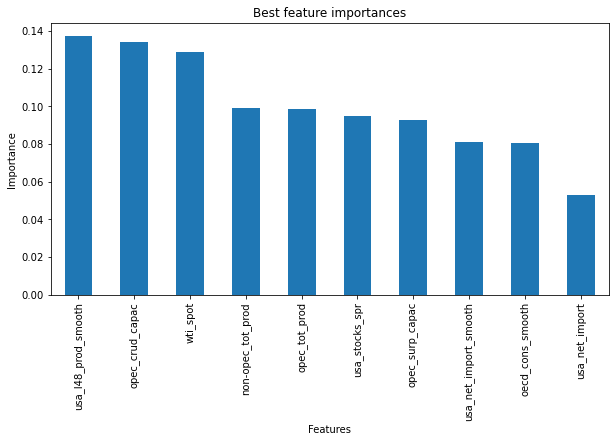

In [19]:
feat_imp(RF_base_pipe)

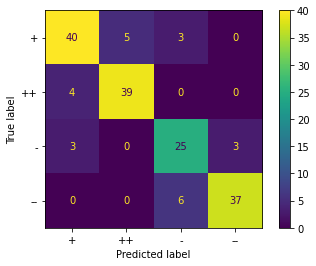

In [20]:
plot_confusion_matrix(RF_base_pipe,X_test,y_test)

In [21]:
model = RandomForestClassifier(random_state=42)
scaler = StandardScaler()

grid_params = {
    'model__n_estimators': [103], #np.arange(start=90,stop=110,step=1),
    'model__max_depth': [8], #np.arange(1,15,step=1),
    'model__criterion': ['entropy'], #['gini','entropy'],
    'model__max_features': [2], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

model_name = 'RFC_pos_neg_class'

RF_pnm_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

RF_pnm_pipe.fit(X_train,y_train)

y_pred = RF_pnm_pipe.predict(X_test)

add_model_score(RF_pnm_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_pos_neg_class,0.830303,0.826906,0.832617,0.830303,0.863636,0.8125,0.727273,0.9,0.883721,0.8125,0.774194,0.837209,0.945455,8


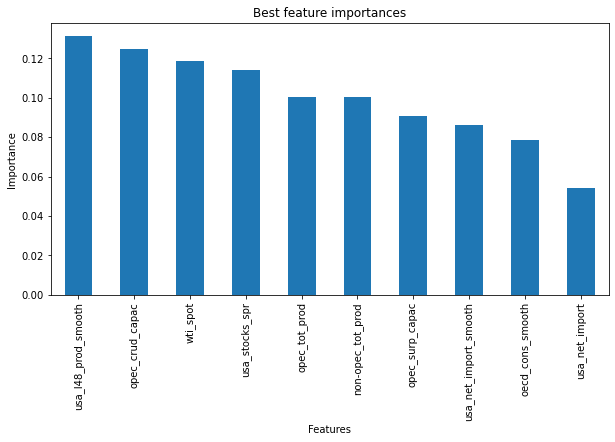

In [22]:
feat_imp(RF_pnm_pipe)

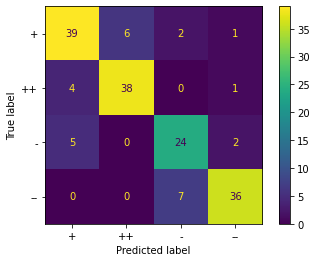

In [23]:
plot_confusion_matrix(RF_pnm_pipe,X_test,y_test)

In [24]:
model = RandomForestClassifier(random_state=42)
scaler = StandardScaler()

grid_params = {
    'model__n_estimators': [69], #np.arange(start=60,stop=80,step=1),
    'model__max_depth': [9], #np.arange(1,15,step=1),
    'model__criterion': ['entropy'], #['gini','entropy'],
    'model__max_features': [3], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

model_name = 'RFC_neg_recall'

RF_neg_rec_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=recall_neg_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

RF_neg_rec_pipe.fit(X_train,y_train)

y_pred = RF_neg_rec_pipe.predict(X_test)

add_model_score(RF_neg_rec_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_neg_recall,0.842424,0.837928,0.845481,0.842424,0.866667,0.833333,0.727273,0.923077,0.906977,0.833333,0.774194,0.837209,0.963636,9


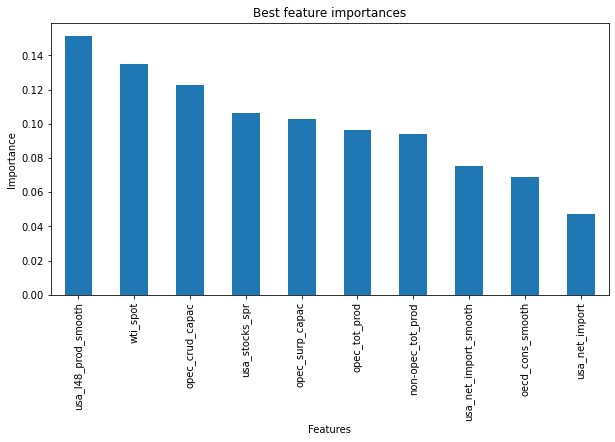

In [25]:
feat_imp(RF_neg_rec_pipe)

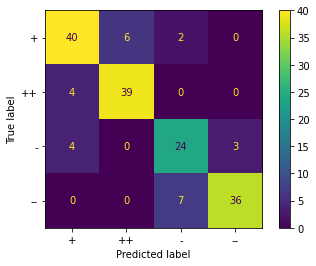

In [26]:
plot_confusion_matrix(RF_neg_rec_pipe,X_test,y_test)

In [27]:
model_score.sort_values(by='pos neg class',ascending=False).head(3)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base,0.854545,0.851807,0.857781,0.854545,0.886364,0.851064,0.735294,0.925,0.906977,0.833333,0.806452,0.860465,0.963636,None
RFC_neg_recall,0.842424,0.837928,0.845481,0.842424,0.866667,0.833333,0.727273,0.923077,0.906977,0.833333,0.774194,0.837209,0.963636,9
RFC_pos_neg_class,0.830303,0.826906,0.832617,0.830303,0.863636,0.8125,0.727273,0.9,0.883721,0.8125,0.774194,0.837209,0.945455,8


Two main insights into the modelling so far. 
1. Basic random forest optimisation has overall better results compared to tuned hyperparameters. 
2. The extreme classes for positive and negative have good precision, however, the less extreme classes have the highest tendencies for false negatives.
3. The model test performance depends on the train, test split and class imbalance. Here, the weakest performing model is the class with the smallest proportion (-).

Unlike the regression modelling which did not show a very high feature importance for wti_spot prices, the classification problem is showing much more significance to one of the most highly correlated features in the EDA.

## XGBClassifier

In [28]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')

model_name = 'XGB_base'

grid_params={}

XGB_base_pipe = GridSearchCV(Pipeline([('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

XGB_base_pipe.fit(X_train,y_train)

y_pred = XGB_base_pipe.predict(X_test)

add_model_score(XGB_base_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
XGB_base,0.8,0.802509,0.808,0.8,0.804348,0.795455,0.675676,0.921053,0.860465,0.729167,0.806452,0.813953,0.945455,None


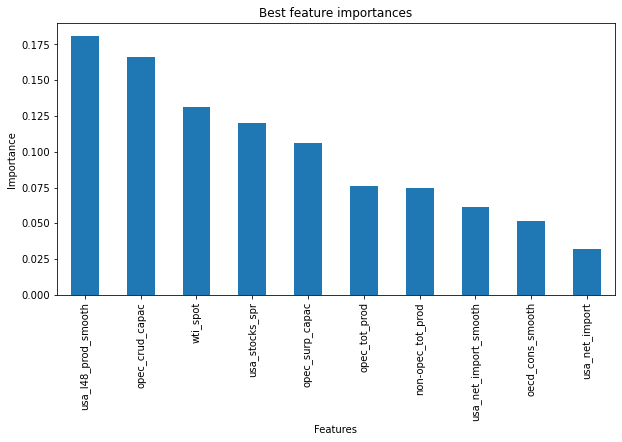

In [29]:
feat_imp(XGB_base_pipe)

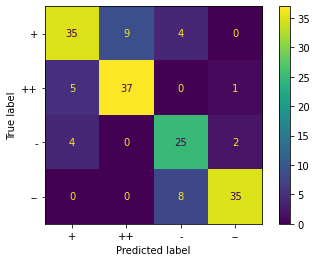

In [30]:
plot_confusion_matrix(XGB_base_pipe,X_test,y_test)

In [31]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')
scaler = StandardScaler()

model_name = 'XGB_pos_neg_class'

grid_params = {
    'model__learning_rate': [0.2], #np.arange(0.1,1,step=0.05),
    'model__n_estimators': [41], #np.arange(30,50,step=1),
    'model__max_depth' : [2], #np.arange(1,10,step=1),
    'model__gamma' : [0.7], #np.arange(0,1,step=0.1),
    'model__lambda' : [0.3], #np.arange(0,1.1,step=0.1),
    'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

XGB_gscv_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

XGB_gscv_pipe.fit(X_train,y_train)

y_pred = XGB_gscv_pipe.predict(X_test)

add_model_score(XGB_gscv_pipe,model_name,y_test,y_pred)


,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
XGB_pos_neg_class,0.8,0.799653,0.81289,0.8,0.863636,0.8,0.615385,0.918919,0.883721,0.75,0.774194,0.790698,0.927273,2


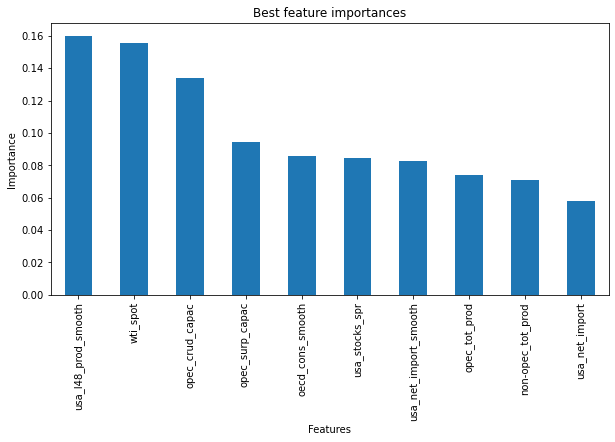

In [32]:
feat_imp(XGB_gscv_pipe)

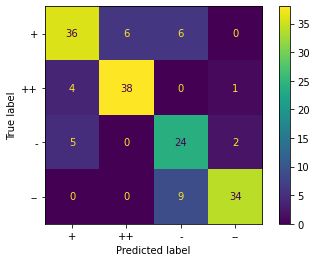

In [33]:
plot_confusion_matrix(XGB_gscv_pipe,X_test,y_test)

In [34]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')
scaler = StandardScaler()

model_name = 'XGB_neg_recall'

grid_params = {
    'model__learning_rate': [0.59], #np.arange(0.4,1,step=0.01),
    'model__n_estimators': [25], #np.arange(20,50,step=1),
    'model__max_depth' : [2], #np.arange(1,10,step=1),
    'model__gamma' : [0.7], #np.arange(0,1,step=0.1),
    'model__lambda' : [0.3], #np.arange(0,1.1,step=0.05),
    'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

XGB_neg_rec_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=recall_neg_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

XGB_neg_rec_pipe.fit(X_train,y_train)

y_pred = XGB_neg_rec_pipe.predict(X_test)

add_model_score(XGB_neg_rec_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
XGB_neg_recall,0.781818,0.769142,0.7883,0.781818,0.837209,0.696429,0.678571,0.921053,0.837209,0.8125,0.612903,0.813953,0.915152,2


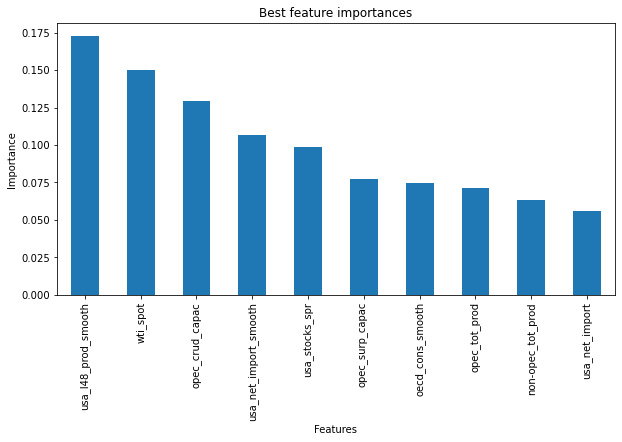

In [35]:
feat_imp(XGB_neg_rec_pipe)

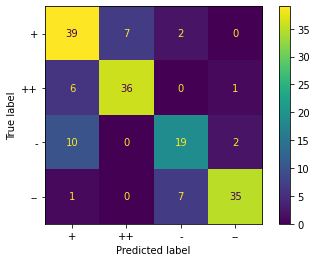

In [36]:
plot_confusion_matrix(XGB_neg_rec_pipe,X_test,y_test)

In [37]:
model_score.sort_values(by=['pos neg class','recall avg'],ascending=False)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base,0.854545,0.851807,0.857781,0.854545,0.886364,0.851064,0.735294,0.925,0.906977,0.833333,0.806452,0.860465,0.963636,None
RFC_neg_recall,0.842424,0.837928,0.845481,0.842424,0.866667,0.833333,0.727273,0.923077,0.906977,0.833333,0.774194,0.837209,0.963636,9
RFC_pos_neg_class,0.830303,0.826906,0.832617,0.830303,0.863636,0.8125,0.727273,0.9,0.883721,0.8125,0.774194,0.837209,0.945455,8
XGB_base,0.8,0.802509,0.808,0.8,0.804348,0.795455,0.675676,0.921053,0.860465,0.729167,0.806452,0.813953,0.945455,None
XGB_pos_neg_class,0.8,0.799653,0.81289,0.8,0.863636,0.8,0.615385,0.918919,0.883721,0.75,0.774194,0.790698,0.927273,2
XGB_neg_recall,0.781818,0.769142,0.7883,0.781818,0.837209,0.696429,0.678571,0.921053,0.837209,0.8125,0.612903,0.813953,0.915152,2
baseline_dummy_class,0.260606,0.250352,0.26108,0.260606,0.210526,0.375,0.147059,0.266667,0.186047,0.375,0.16129,0.27907,0.509091,NaN
KMeans_base,0.109091,0.119628,0.13212,0.109091,0.166667,0.0877193,0.258065,0.056338,0.0232558,0.104167,0.258065,0.0930233,0.430303,NaN


### Summary

* The most important measurement of model performance here is to be able to correctly predict a positive, or negative change. This is defined as the "positive negative classification".
* Second is to reduce the misclassification from exteme opposites ('--' to '++')
* Finally, accuracy, precision, recall.

The RFC / XGB models consistently preform well (better than 25% random guess, dummy classifier, and KMeans), and perform better than 90% for the positive and negative classification, in addition to 80% for precision and recall.

The XGB models are much simpler (max depth = 2), however the accuracy of the models is worse by a few points across the board.

With the accuracy of the model prediction being absolutely key to the value of the model, RFC will be used for final model choice despite the more complicated parameters.

In [39]:
from joblib import dump, load

model_out = dump(RF_base_pipe, 'best_model.joblib')
model_in = load('best_model.joblib')

y_pred = model_in.predict(X_test)

add_model_score(model_in,'RFC_base_import',y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base_import,0.854545,0.851807,0.857781,0.854545,0.886364,0.851064,0.735294,0.925,0.906977,0.833333,0.806452,0.860465,0.963636,None


### Review of model mis-classifications

#### True '+', Predicted '-'

In [ ]:
y_comb = pd.concat([y_test,pd.Series(y_pred,index=y_test.index),pct_change_test['rig_pct_change_week+8']],ignore_index=True,axis=1)
y_comb.columns = ['test','pred','pct_change']

df_quantiles = pd.read_csv(data_processed_dir+'quantiles.csv',index_col=0).loc['week+8',:]

print(df_quantiles)

def misclass_check(y_comb,test_val,pred_val):
    misclass = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)]
    
    inc_index = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)].sort_index().index.to_list()
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.date,df['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
    ax.scatter(df.date[inc_index],df['Total US RigCount'][inc_index],c='r',alpha=1,s=10,label='data')
    ax.scatter(df.date[[x-8 for x in inc_index]],df['Total US RigCount'][[x-8 for x in inc_index]],c='g',alpha=1,s=10,label='predicted')

    ax.legend()
    
    plt.show()
    
    return misclass

In [ ]:
misclass_check(y_comb,'+','-')

Index 461 is a very small increase, close to zero. Indeces 141 and 381 are farther away from zero but close to zero. Again, not a very significant issue for these borderline classifications.

#### True '-', Predicted '+'

In [ ]:
misclass_check(y_comb,'-','+')

Indeces 104 and 423 have no change. Index 423 is less than a percent decrease. These misclassifications are very close to the border between class bins.

#### True '++', Predicted '+'

In [ ]:
misclass_check(y_comb,'++','+')

#### True '+', Predicted '++'

In [ ]:
misclass_check(y_comb,'+','++')

#### True '--', Predicted '-'

In [ ]:
misclass_check(y_comb,'--','-')

#### True '-', Predicted '--'

In [ ]:
misclass_check(y_comb,'-','--')